In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import database_utils
from configparser import ConfigParser

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})
configparser = ConfigParser()
configparser.read('conf\config.cfg')
db_handle, table_name =  database_utils.initialize_mysql_db_and_table_name_from_config(configparser)

In [3]:
database_queary = """SELECT * FROM (SELECT scenario_name, approach, metric, impact_factor, ranking_error, borda_score, stopping_criteria, COUNT(fold) as folds, AVG(result) as results FROM `middle_evaluation_vs_other_approaches_one`
GROUP By scenario_name, approach, metric, impact_factor, ranking_error, borda_score, stopping_criteria
UNION
SELECT scenario_name, approach, metric, impact_factor, ranking_error, borda_score, stopping_criteria, COUNT(fold) as folds, AVG(result) as results FROM `middle_evaluation_vs_other_approaches_two`
GROUP By scenario_name, approach, metric, impact_factor, ranking_error, borda_score, stopping_criteria) as t1
WHERE folds >= 10"""

df = pd.read_sql(database_queary, db_handle)

In [4]:
df.approach.unique()


array(['CombinedForest with 100 trees, average_runtimes as consensus, 0.7 of features and mu = 10',
       'Expectation_algorithm_survival_forest', 'isac',
       'per_algorithm_RandomForestRegressor_regressor', 'satzilla-11'],
      dtype=object)

In [5]:
from lib2to3.pgen2.pgen import DFAState
from unittest import result


def scelect_df(df: pd.DataFrame, metric:str, scenario_name: str):
    df = df[(df['metric'] == metric) & (df['scenario_name'] == scenario_name)]
    return df

def select_best_forest(df: pd.DataFrame):
    best_forest_par10 = df[df['approach'] == 'CombinedForest with 100 trees, average_runtimes as consensus, 0.7 of features and mu = 10']['results'].min()
    columns = list(df.columns)
    columns.remove('results')
    columns.remove('folds')
    columns.remove('impact_factor')
    best_forest_config = df[df['results'] == best_forest_par10]
    return df[(df['scenario_name'] == best_forest_config['scenario_name'].values[0])
            & (df['approach'] == best_forest_config['approach'].values[0])
            &( df['metric'] == best_forest_config['metric'].values[0])
            &( df['ranking_error'] == best_forest_config['ranking_error'].values[0])
            &( df['borda_score'] == best_forest_config['borda_score'].values[0])
            &( df['stopping_criteria'] == best_forest_config['stopping_criteria'].values[0])
    ]

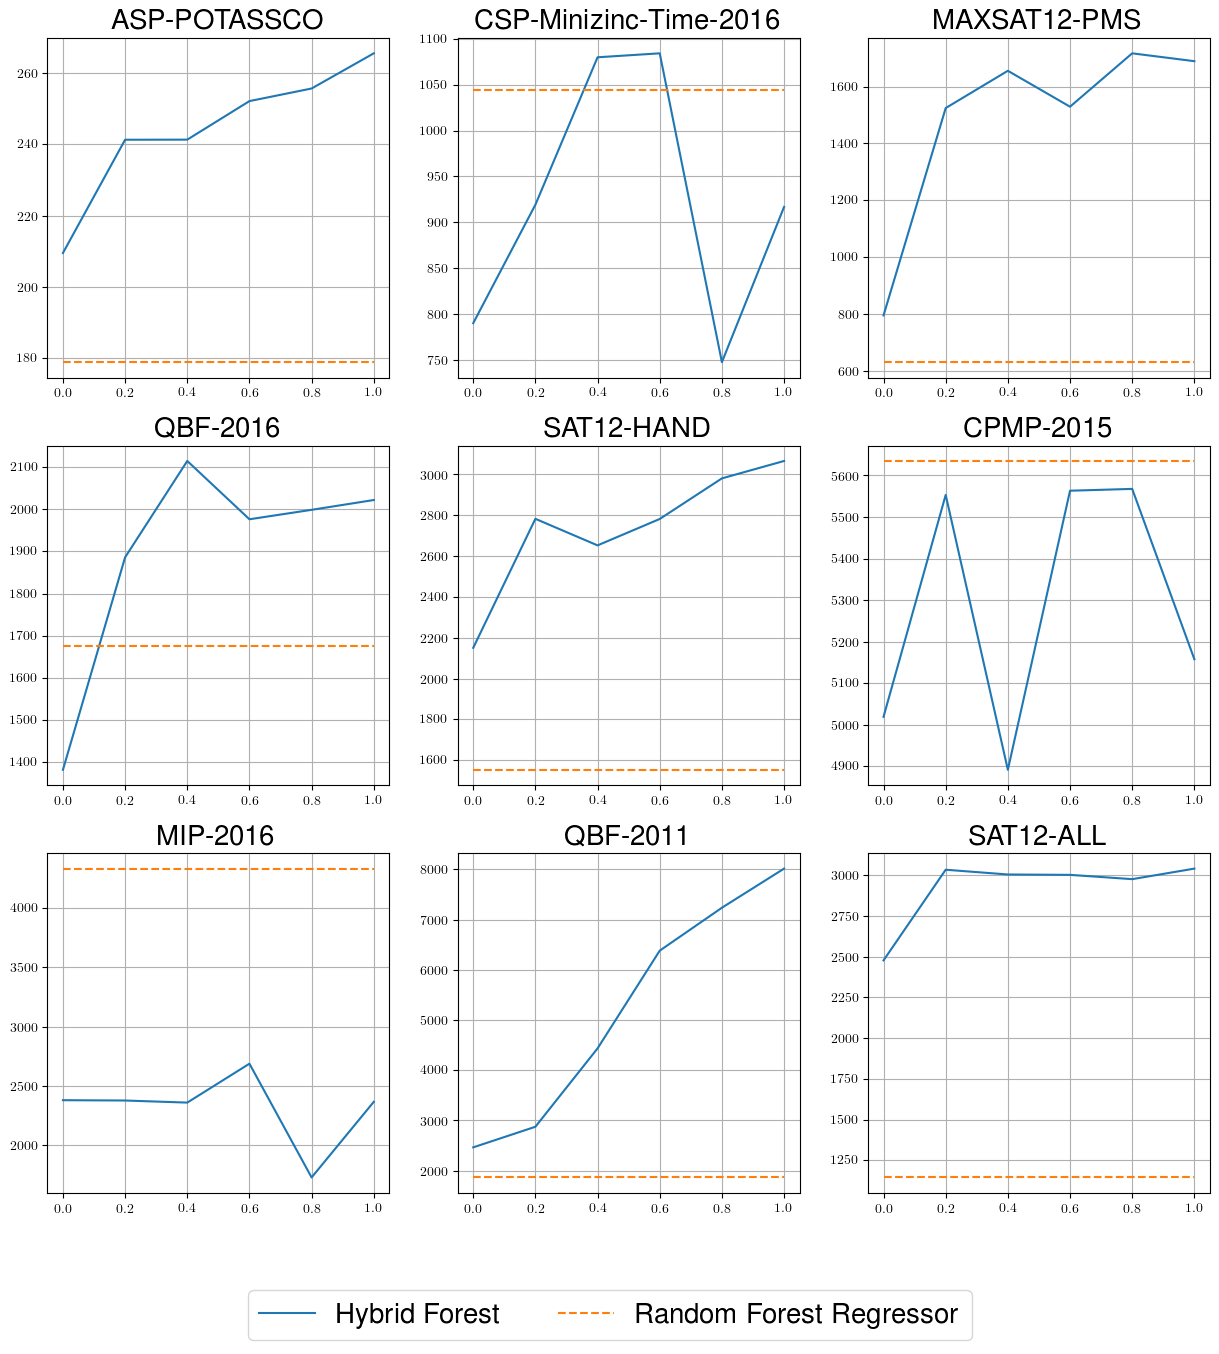

In [34]:

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

axs = axs.flatten()
for plot_number, scenario_name in enumerate(df['scenario_name'].unique()):
    axs[plot_number].grid()
    axs[plot_number].set_title(scenario_name, fontsize=20)
    #axs[plot_number].set_xlabel(r'$\lambda$', fontsize=20)
    #axs[plot_number].set_ylabel('Normalizeded Par10 Score', fontsize=15)
    
    modified_df = scelect_df(df, 'par10', scenario_name)
    best_forest = select_best_forest(modified_df)
    label = f'Hybrid Forest'
    impact_factor = [0,0.2,0.4,0.6,0.8,1]
    best_forest_values = best_forest['results'].values
    axs[plot_number].plot(impact_factor, best_forest_values, label = label)
    axs[plot_number].plot([0,1], modified_df[modified_df['approach'] == 'per_algorithm_RandomForestRegressor_regressor']['results'].tolist()*2, label = 'Random Forest Regressor', linestyle='dashed')
lines, labels = axs[plot_number].get_legend_handles_labels()
leg = fig.legend(lines, labels, loc = 'lower center', ncol=2, fontsize=20)
box_postion = leg.get_bbox_to_anchor().inverse_transformed(axs[plot_number].transAxes)


In [29]:
box_postion

Bbox([[-2.948387096774192, -0.4857142857142857], [1.4387096774193542, 3.929870129870131]])